In [25]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn2

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [26]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

```
%cd data
!wget https://zenodo.org/record/4719436/files/velocity_anndata_mouse_embryonic_stem_cells_DeepCycle_ISMARA.h5ad?download=1 
%cd ..
```

In [27]:
their_adata = ad.read_h5ad('data/velocity_anndata_mouse_embryonic_stem_cells_DeepCycle_ISMARA.h5ad')
their_adata.var_names_make_unique
their_barcodes = np.array([bc[-17:-1] for bc in their_adata.obs_names])
print(statistics.median(their_adata.X.sum(axis=1)))
their_adata

[[7413.4844]]


AnnData object with n_obs × n_vars = 5637 × 12238
    obs: 'Clusters', '_X', '_Y', 'n_genes', 'percent_mito', 'n_counts', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'louvain', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'cell_cycle_theta'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'ISMARA_activities', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'uns

In [28]:
adata = ad.read_h5ad('/home/mffang/data/counts/DeepCycle_2020/mESC/counts_filtered/adata.h5ad')

cell_idx = [np.where(adata.obs_names==bc)[0][0] for bc in their_barcodes]
adata = adata[cell_idx]
adata

View of AnnData object with n_obs × n_vars = 5637 × 34285
    layers: 'ambiguous', 'mature', 'nascent'

In [29]:
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

/tmp/ipykernel_210410/1221925009.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_id'] = adata.var_names


,gene_id
ENSMUSG00000100764,ENSMUSG00000100764.2
ENSMUSG00000100635,ENSMUSG00000100635.2
ENSMUSG00000100480,ENSMUSG00000100480.2
ENSMUSG00000051285,ENSMUSG00000051285.18
ENSMUSG00000097797,ENSMUSG00000097797.7
...,...
ENSMUSG00000094799,ENSMUSG00000094799.2
ENSMUSG00000095019,ENSMUSG00000095019.2
ENSMUSG00000094915,ENSMUSG00000094915.2
ENSMUSG00000079808,ENSMUSG00000079808.4


/tmp/ipykernel_210410/259953683.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


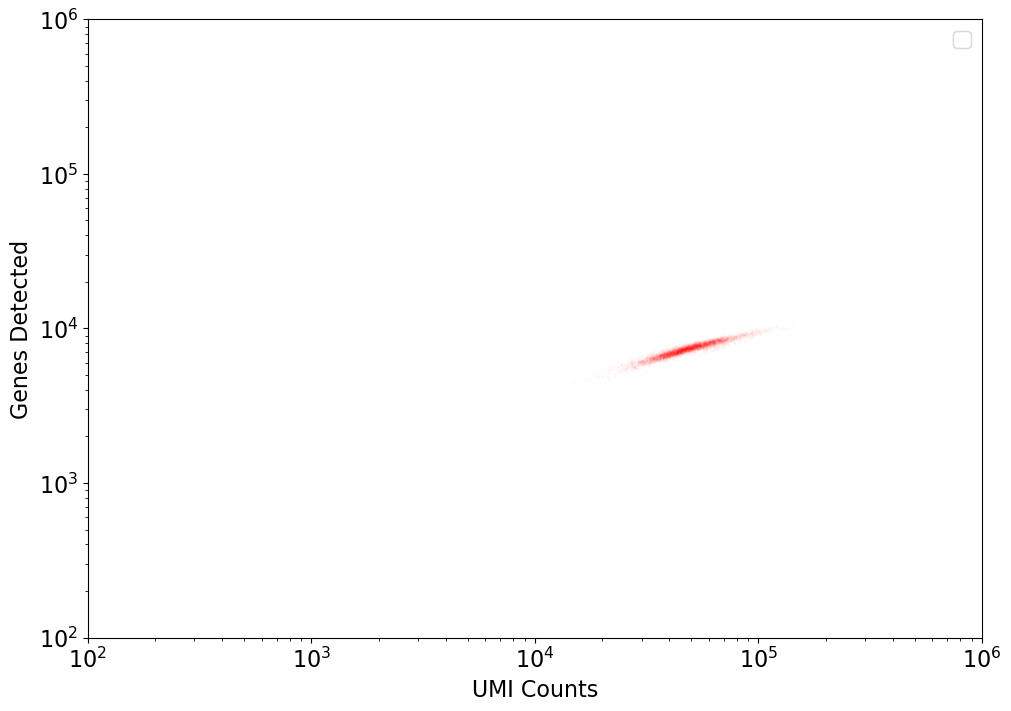

In [30]:
adata.X = adata.layers['ambiguous']+adata.layers['mature']+adata.layers['nascent']

fig, ax = plt.subplots(figsize=(10, 7))

mtx = adata.X
ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="red", s=1, alpha=0.01)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e2,1e6))
ax.set_ylim((1e2,1e6))

plt.legend()

In [31]:
statistics.median(mtx.sum(axis=1))

matrix([[47469.]], dtype=float32)

## Check gene expresmion of two marker genes

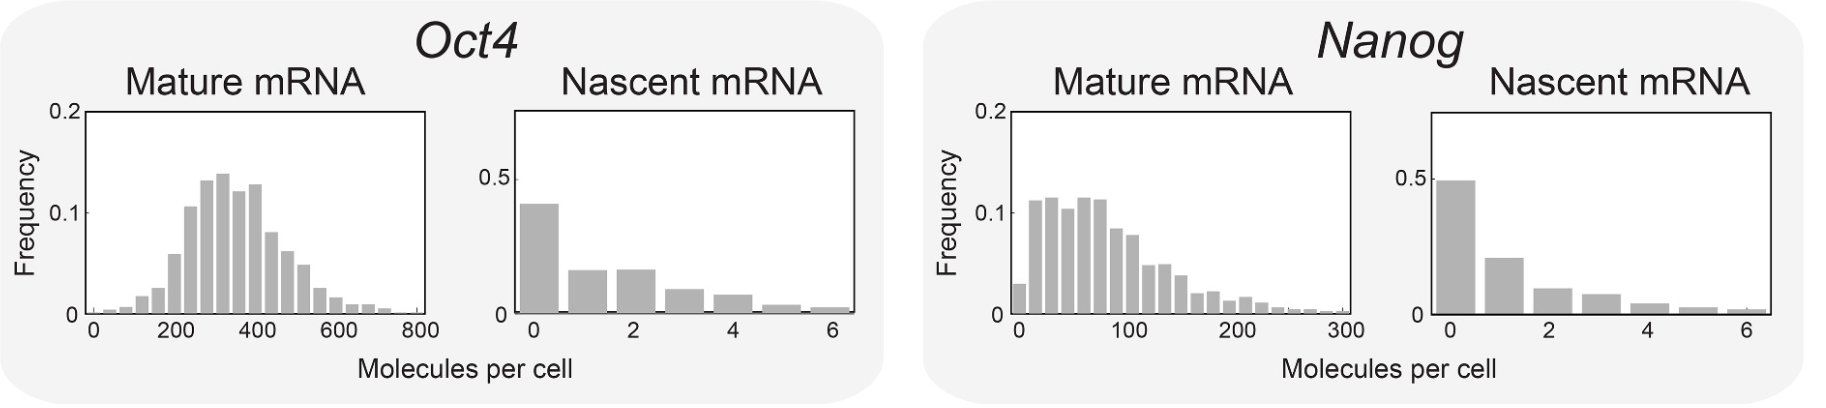

Text(0.5, 1.0, 'mature+ambiguous')

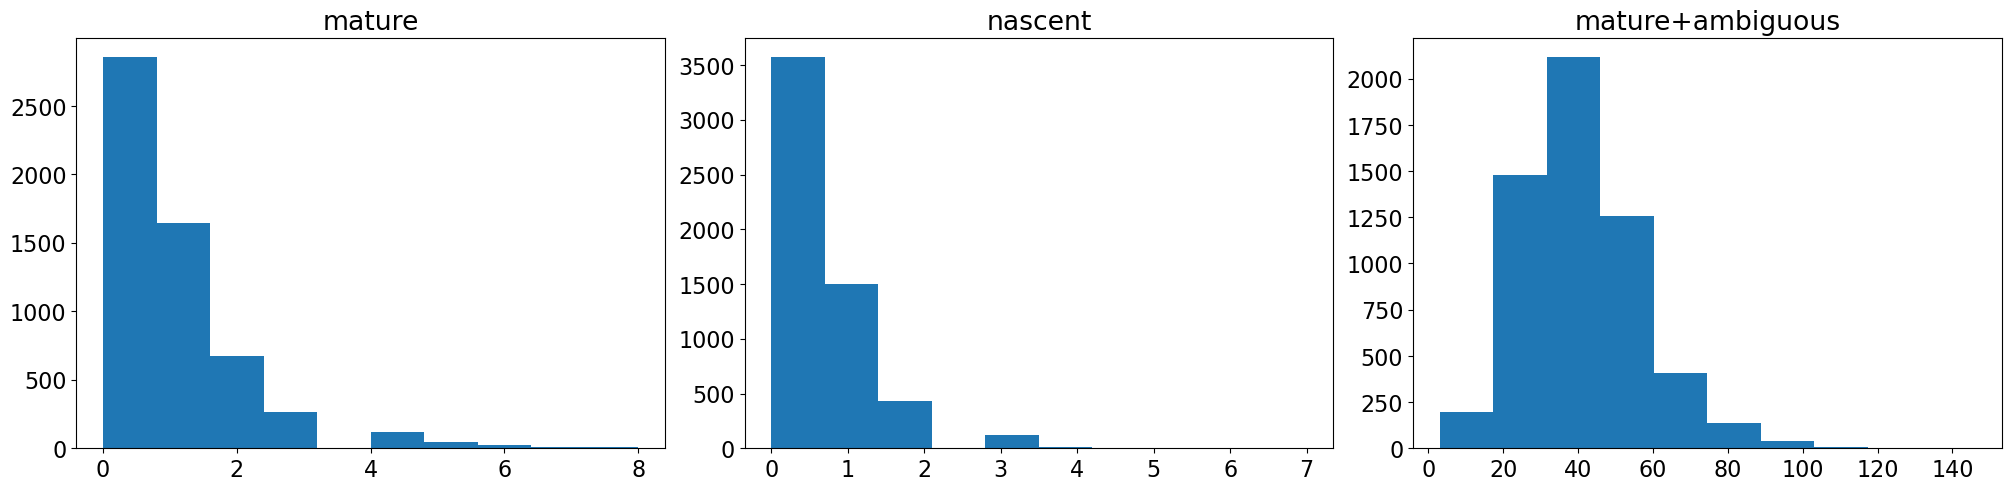

In [32]:
# Oct4
fig, axs = plt.subplots(1,3,figsize=(20,4.8))
axs[0].hist(adata.layers["mature"].toarray()[:,adata.var_names.isin(["ENSMUSG00000024406"])])
axs[1].hist(adata.layers["nascent"].toarray()[:,adata.var_names.isin(["ENSMUSG00000024406"])])
axs[2].hist((adata.layers["mature"]+adata.layers["ambiguous"]).toarray()[:,adata.var_names.isin(["ENSMUSG00000024406"])])

axs[0].set_title('mature')
axs[1].set_title('nascent')
axs[2].set_title('mature+ambiguous')

Text(0.5, 1.0, 'mature+ambiguous')

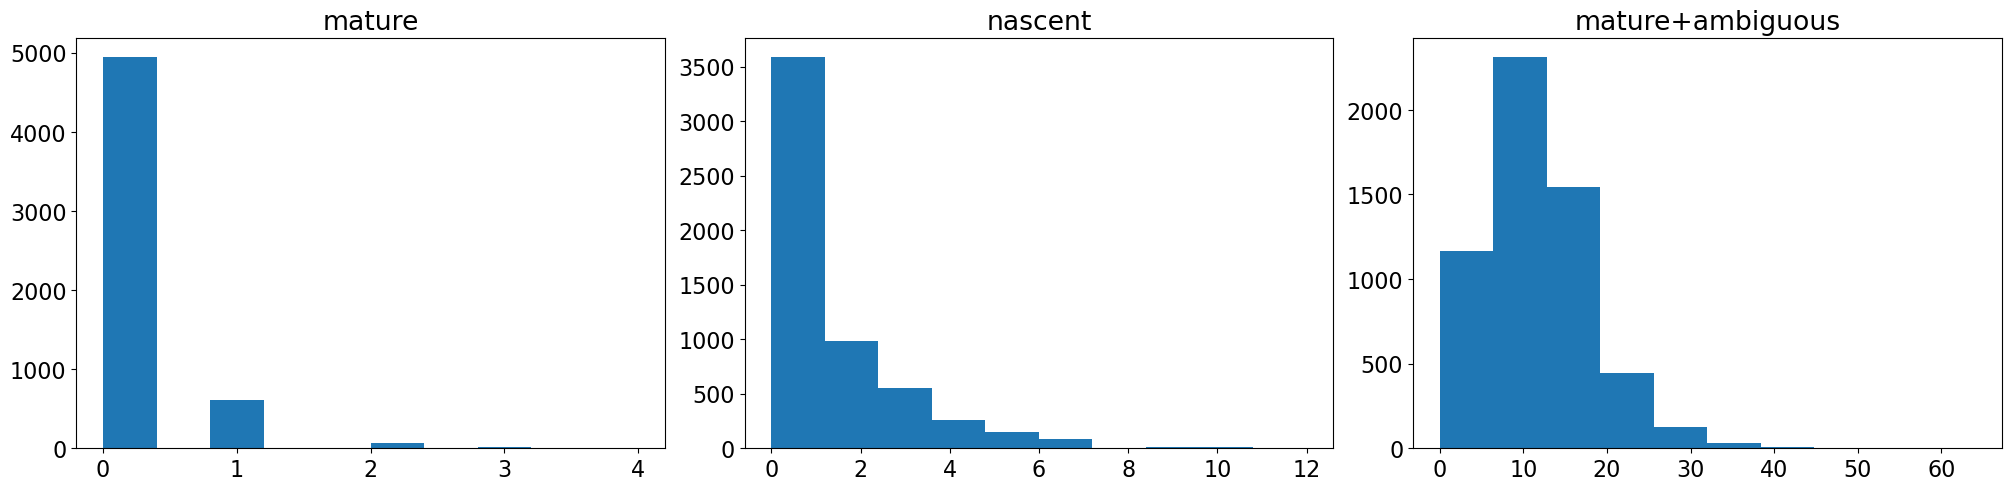

In [33]:
# Nanog
fig, axs = plt.subplots(1,3,figsize=(20,4.8))
axs[0].hist(adata.layers["mature"].toarray()[:,adata.var_names.isin(["ENSMUSG00000012396"])])
axs[1].hist(adata.layers["nascent"].toarray()[:,adata.var_names.isin(["ENSMUSG00000012396"])])
axs[2].hist((adata.layers["mature"]+adata.layers["ambiguous"]).toarray()[:,adata.var_names.isin(["ENSMUSG00000012396"])])

axs[0].set_title('mature')
axs[1].set_title('nascent')
axs[2].set_title('mature+ambiguous')

# Calculate normalized covariance

In [34]:
adata.layers['spliced'] = adata.layers['ambiguous']+adata.layers['mature']

0.17198573 0.3995418 0.88660324


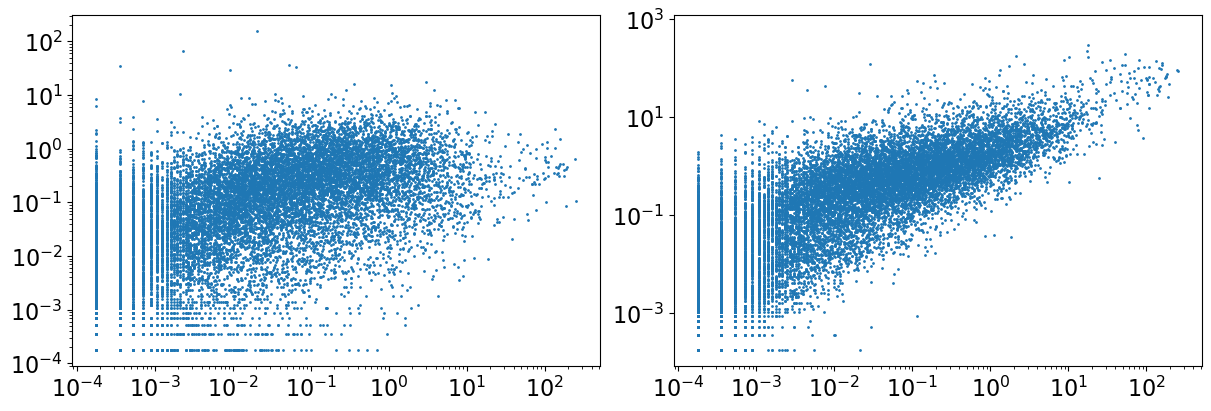

In [35]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

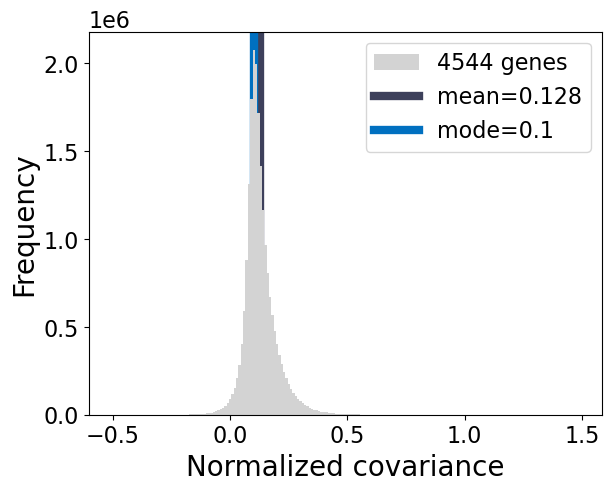

In [36]:
fig,axs = plt.subplots(1,1,figsize=(6,4.8))
_ = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

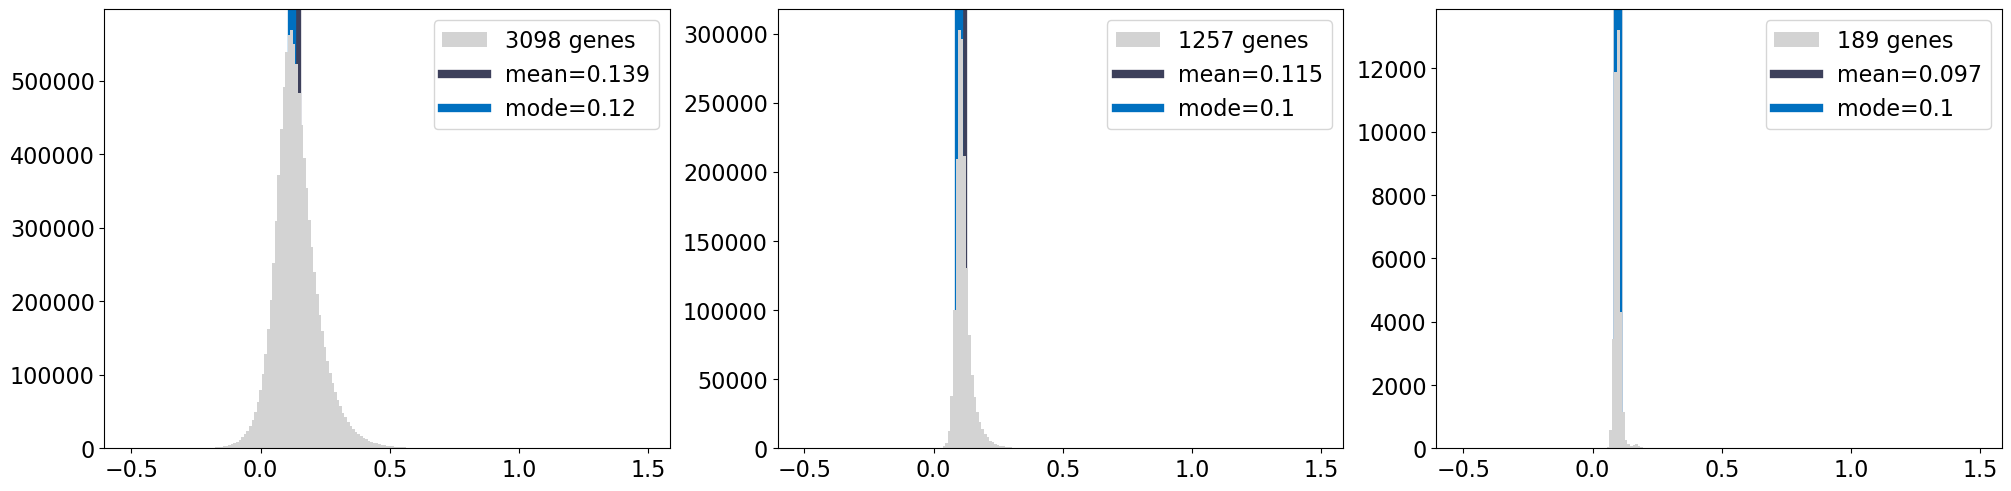

In [11]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10)

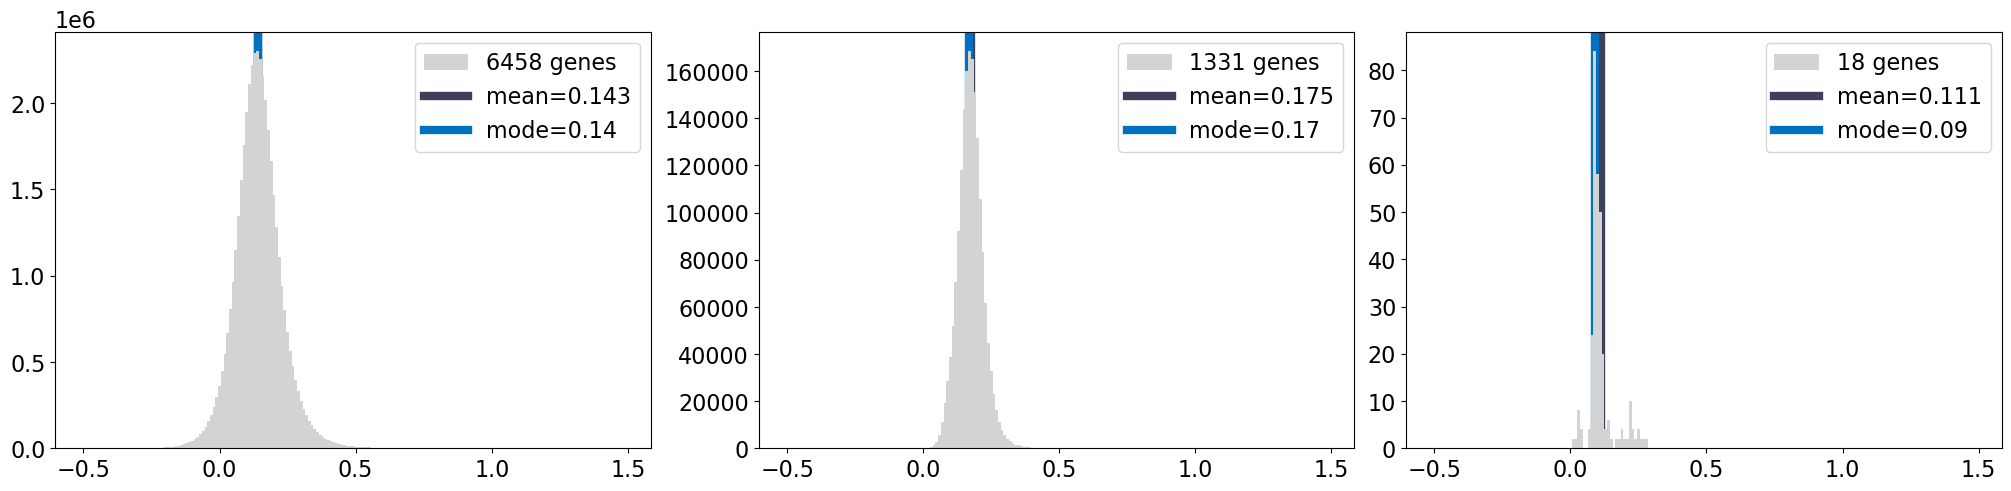

In [12]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=10)

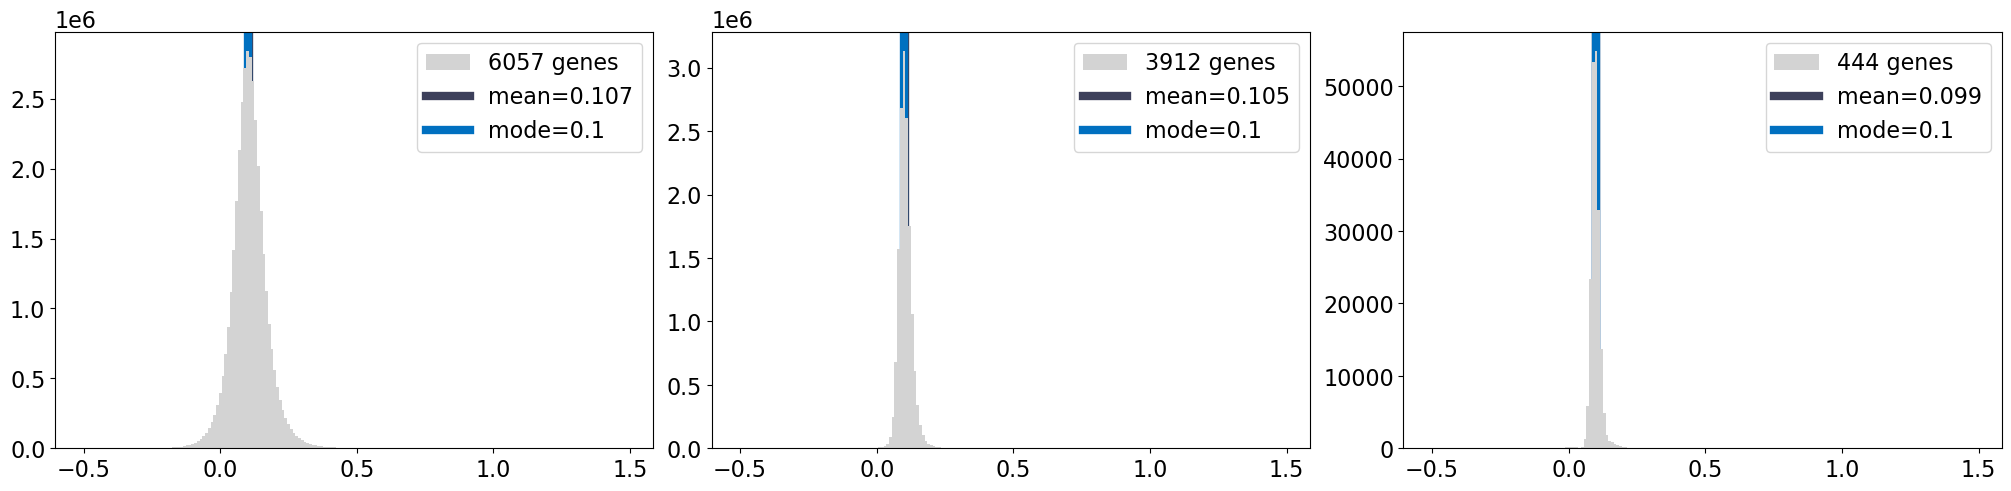

In [13]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf)

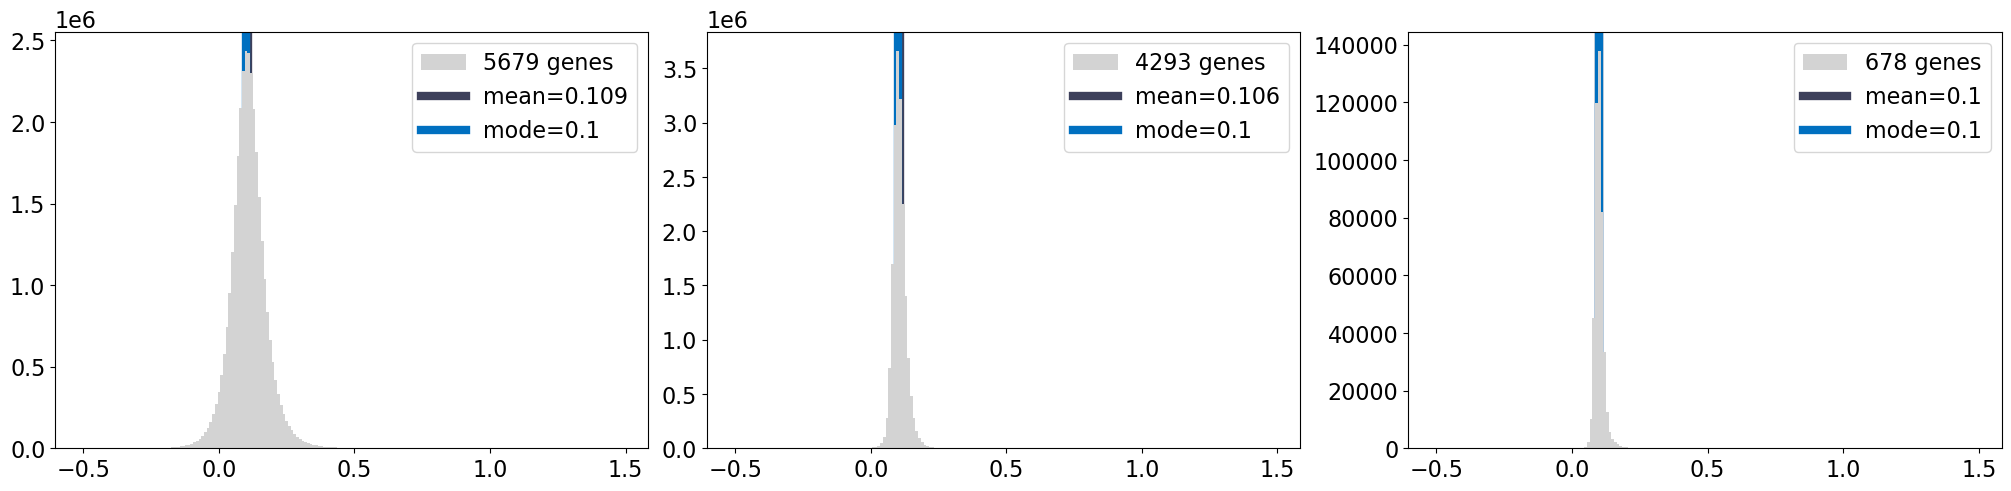

In [16]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[2],min_mean=10)

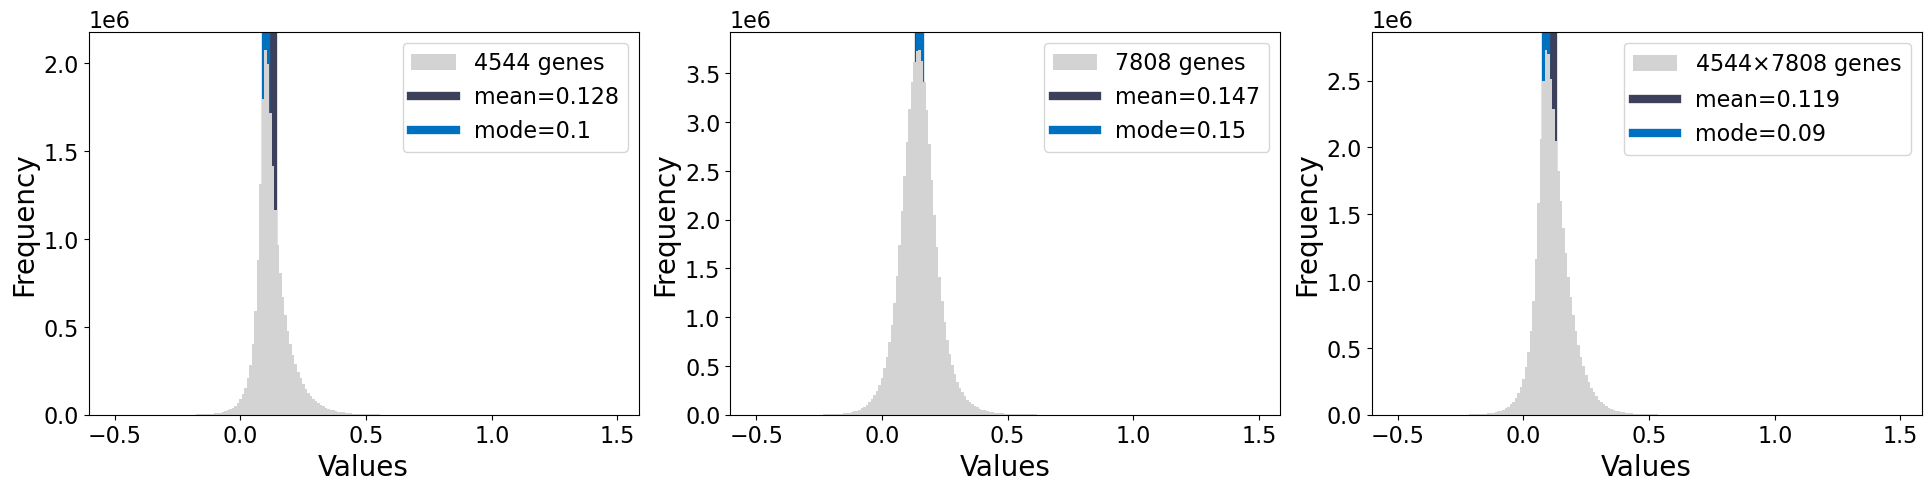

In [14]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["nascent"].toarray(),ax=axs[1],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["mature"].toarray(),N2=adata.layers["nascent"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

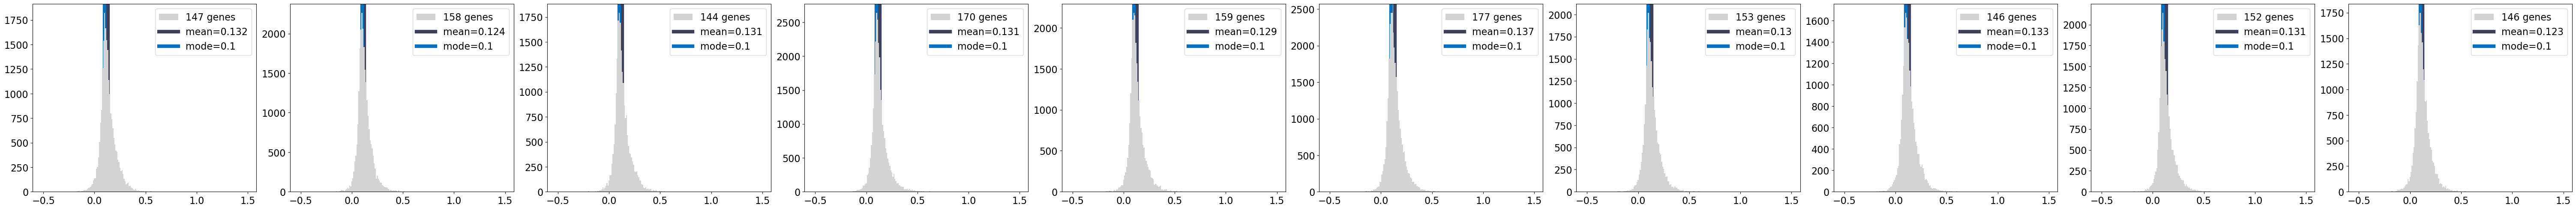

In [83]:
fig,axs = plt.subplots(1,10,figsize=(60,4.8))
B = 10
s_bootrapping_genes = []

n,p = adata.shape
np.random.seed(2025)
for b in range(B):
    idx = np.random.choice(p,10000,replace=False)
    data = adata.layers["mature"].toarray()[:,idx]
    s_bootrapping_genes[b] = estimate_s(N1=data,ax=axs[b],min_mean=0.1,var_threshold=np.inf,n_iter=0)

100%|██████████| 1000/1000 [03:38<00:00,  4.59it/s]


(array([  5.,   0.,   0.,   0.,   0., 883.,   0.,   0.,   0., 112.]),
 array([0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
        0.108, 0.11 ]),
 <BarContainer object of 10 artists>)

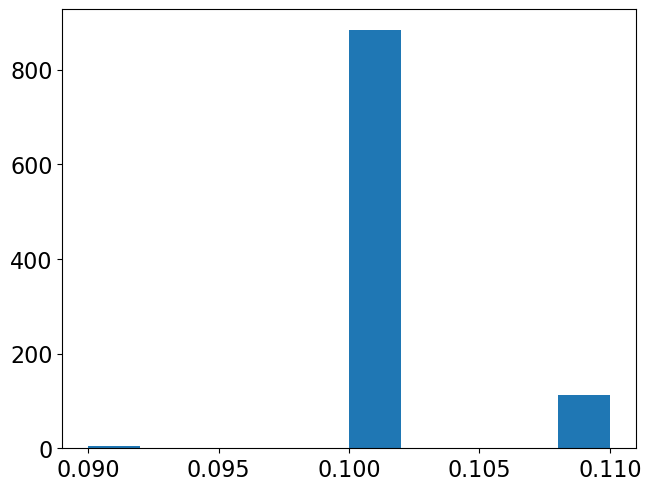

In [42]:
B = 1000
s_bootrapping_cells = []

X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
n,p = X_.shape

np.random.seed(2025)
for b in tqdm(range(B)):
    idx = np.random.choice(n,n,replace=True)
    data = X_[idx]
    s_bootrapping_cells.append(estimate_s(N1=data,plot=False,min_mean=0.1))
plt.hist(s_bootrapping_cells)

# Select Poisson genes by normalized variance

In [40]:
def overdispersion(sampled_datasets,idx,eps=0):
    np.random.seed(idx)
    assert len(sampled_datasets)==1
    n_samples = sampled_datasets[0].shape[0]
    b_idx = np.random.choice(a=n_samples,size=n_samples)
    X = sampled_datasets[0][b_idx]
    assert len(np.shape(X))==2, "sampled_datasets needs to be a list of 2D arrays"
    
    bootstrap_var = X.var(axis=0)
    bootstrap_mean = X.mean(0)

    # Calculate residue (normalized variance)
    eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
    
    return np.array(eta)

In [42]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50)

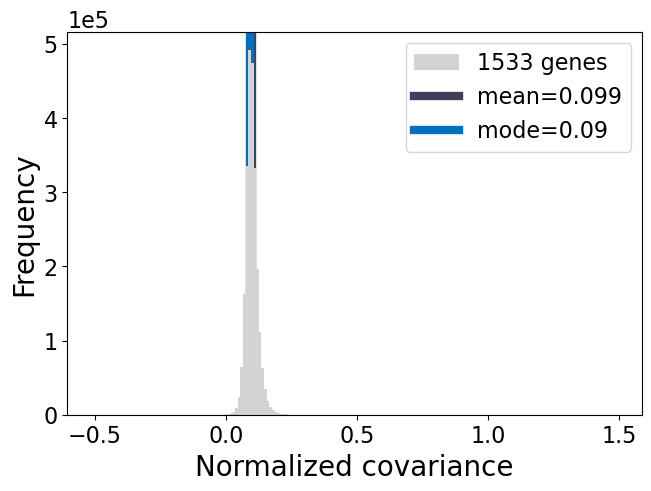

In [68]:
s = 0.1
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['spliced'].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Normalized covariance',fontsize=20)
axs.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

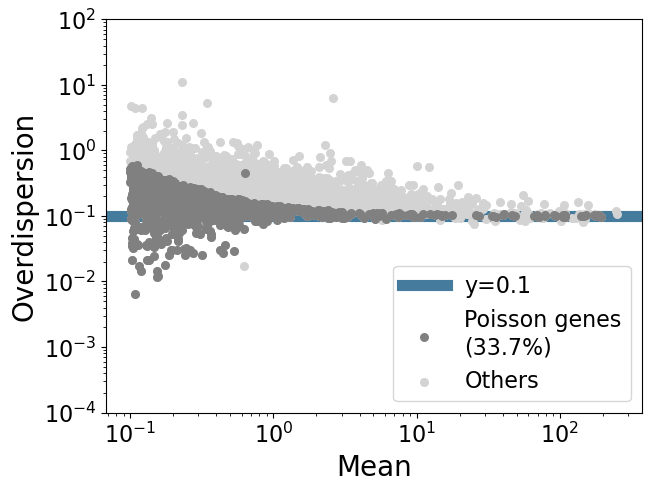

In [69]:
s = 0.1
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

Text(0.5, 0, 'Values')

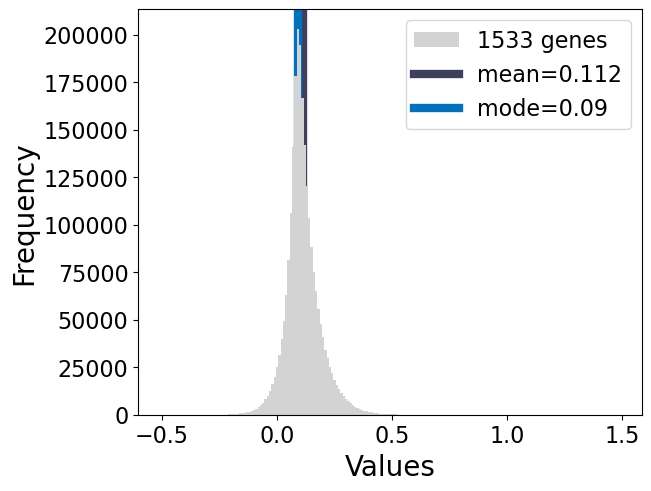

In [46]:
s = 0.1
S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers['mature'].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)


In [89]:
X_ = adata.layers['nascent'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=50)

Text(0.5, 0, 'Values')

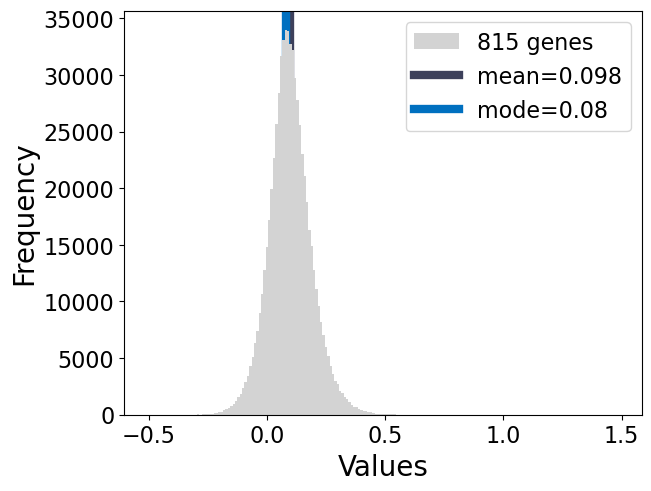

In [90]:
s = 0.09
U_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
U_Pgene = adata.var_names[nonzero_idx][U_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers['nascent'].toarray()[:,idx]
_ = estimate_s(X_U,ax=axs)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

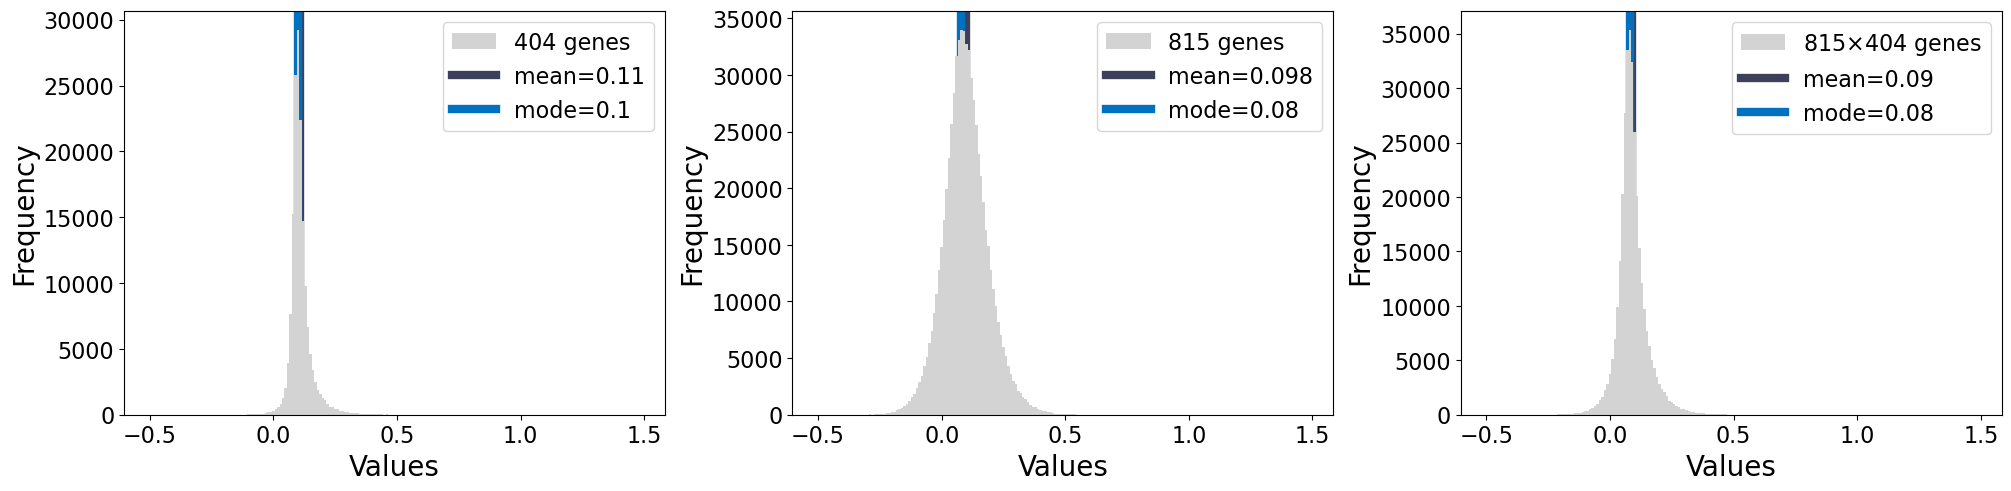

In [91]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs[0])

idx = adata.var_names.isin(U_Pgene)
X_U = adata.layers["nascent"].toarray()[:,idx]
s = estimate_s(X_U,ax=axs[1])

s = estimate_s(N1=X_U,N2=X_S,ax=axs[2])

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [47]:
# Save to text file (each string will be on a new line)
np.savetxt("results/mESC_Pgenes.txt", np.array(S_Pgene), fmt='%s')

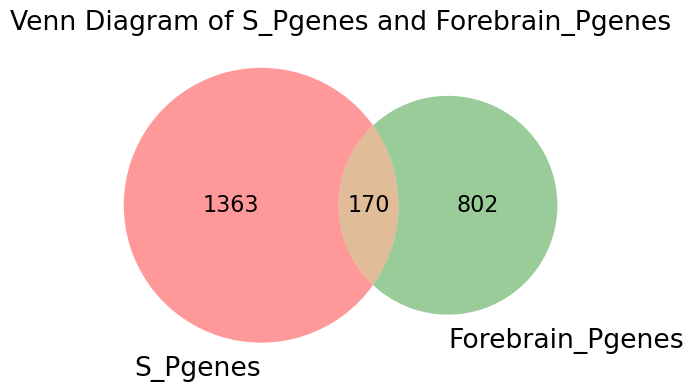

In [48]:
forebrain_Pgenes = np.loadtxt("results/forebrain_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
forebrain_Pgenes_set = set(forebrain_Pgenes)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn2([S_Pgene_set, forebrain_Pgenes_set], set_labels=('S_Pgenes', 'Forebrain_Pgenes'))

# Show the plot
plt.title("Venn Diagram of S_Pgenes and Forebrain_Pgenes")
plt.show()

# Cell size

1533
r=0.97


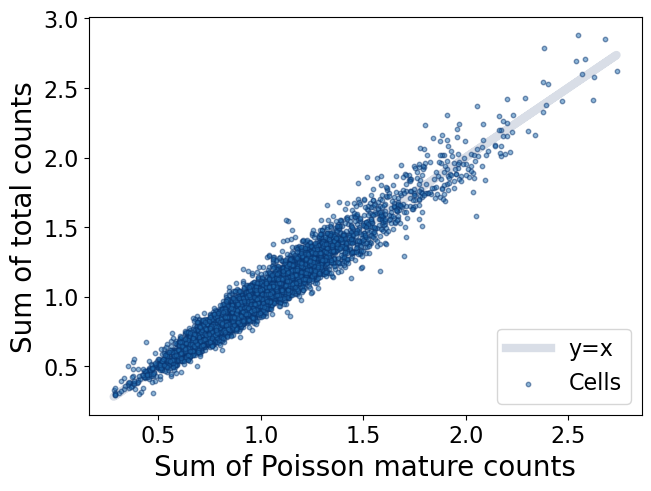

In [72]:
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
cellsize_S = X_[:,S_Pgene_mask].sum(1)
print(S_Pgene_mask.sum())

cellsize_X = adata.X.toarray().copy().sum(1)

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,alpha=0.5,s=10,c='#2070b4',edgecolor='#08326e',label='Cells')
           
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Sum of Poisson mature counts',fontsize=20)
plt.ylabel('Sum of total counts',fontsize=20)
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

Text(0, 0.5, 'Cell size ($\\hat{c}$)')

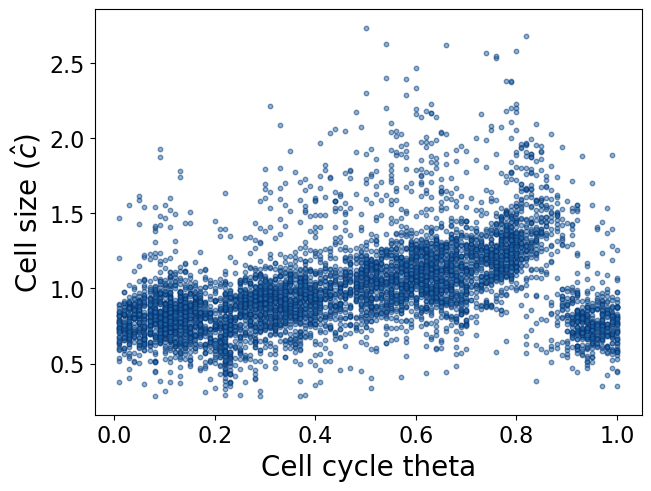

In [57]:
plt.scatter(their_adata.obs['cell_cycle_theta'],cellsize_S/cellsize_S.mean(),alpha=0.5,s=10,c='#2070b4',edgecolor='#08326e',label='Cells')
plt.xlabel('Cell cycle theta',fontsize=20)
plt.ylabel(r'Cell size ($\hat{c}$)',fontsize=20)

Text(0, 0.5, 'Cell size ($\\hat{c}$)')

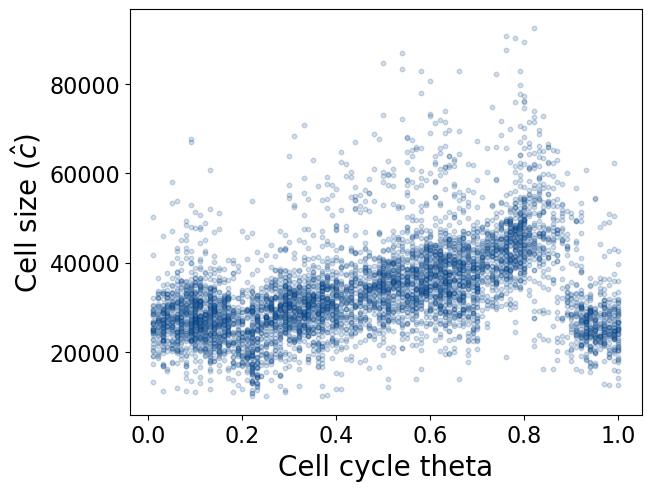

In [67]:
plt.scatter(their_adata.obs['cell_cycle_theta'],their_adata.obs['initial_size'],alpha=0.2,s=10,c='#2070b4',edgecolor='#08326e',label='Cells')
plt.xlabel('Cell cycle theta',fontsize=20)
plt.ylabel(r'Cell size ($\hat{c}$)',fontsize=20)

# Simulation

In [ ]:
c = cellsize_S/cellsize_S.mean()
lam = X_S.mean(0)
XX = np.random.poisson(c[:,None]*lam[None,:])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_S,ax=axs[0])
s_nn = estimate_s_(N1=XX,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

# Check covariance relationships

In [65]:
idx = adata.var_names.isin(adata.var_names)

N = adata.layers["nascent"][:,idx].toarray()
M = adata.layers["mature"][:,idx].toarray() 

idx = (N.mean(0)>1) & (M.mean(0)>1)
N = N[:,idx]
M = M[:,idx]

M_mean = np.mean(M,axis=0)
N_mean = np.mean(N,axis=0)

M_var = np.var(M,axis=0)
N_var = np.var(N,axis=0)

zeta_nn = (N_var-N_mean)/N_mean**2
zeta_mm = (M_var-M_mean)/M_mean**2

cov_nm = []
for i in np.arange(len(N_mean)):
    cov_nm.append(np.cov(N[:,i],M[:,i])[0,1])
    
zeta_nm = np.array(cov_nm)/M_mean/N_mean
zeta_nm.shape

(300,)

## Var(N)

Text(0.5, 1.0, '99.72% of cells >= 0')

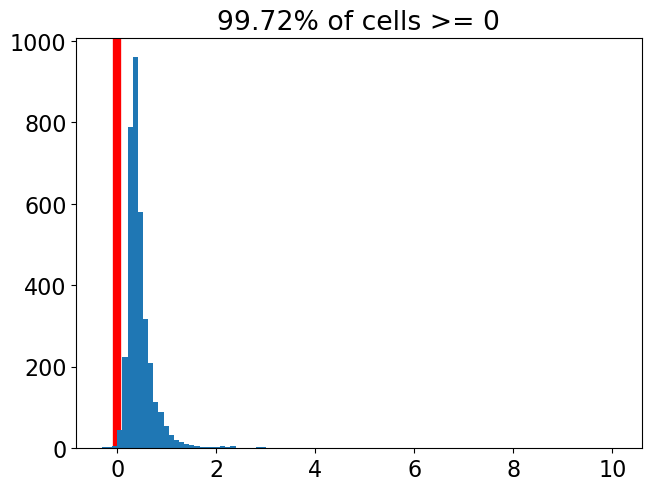

In [12]:
plt.hist(zeta_nn,bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.title(str(np.around(100*(zeta_nn>=0).mean(),2))+'% of cells >= 0')

## Cov(N,M)
$$\zeta_{us}<\zeta_{uu}$$

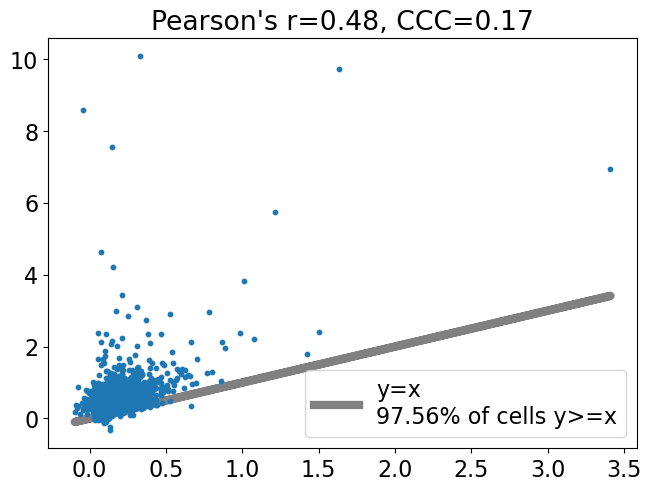

In [13]:
x=zeta_nm
y=zeta_nn

plt.plot(x,x,color='gray',zorder=0,label='y=x\n'+str(np.around(100*(x<=y).mean(),2))+'% of cells y>=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,alpha=1)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

## Var(M)

$$\zeta_{nm}=\zeta_{mm}$$

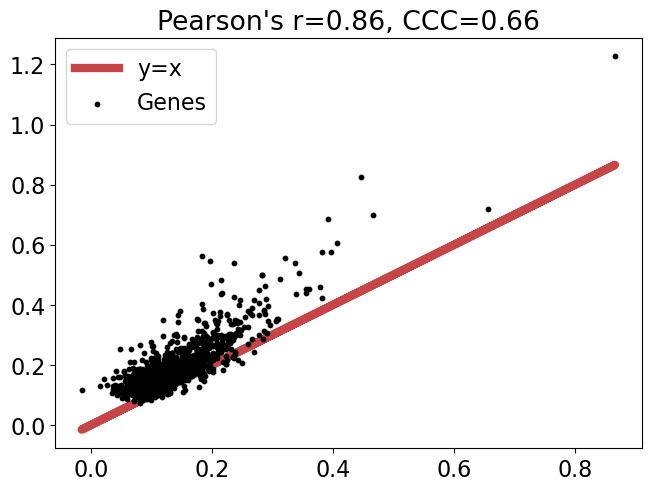

In [57]:
x=zeta_nm
y=zeta_mm

plt.plot(x,x,zorder=0,c=red,label='y=x')
#plt.plot(x,x*2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x*2<=y).mean(),2))+'% of cells y>=2x')
plt.scatter(x,y,s=10,label='Genes',color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$X^m$]')
plt.legend()

In [78]:
lower_bound, upper_bound, delta_eta_bootstrap = bootstrapping_func(delta_eta,[N,M],B=1000,n_cores=10,alpha=0.1)
Bursty_mask = (0 < upper_bound) & (0 > lower_bound) 
Bursty_mask.mean()

0.22333333333333333

Pearson's r=0.814, CCC=0.551


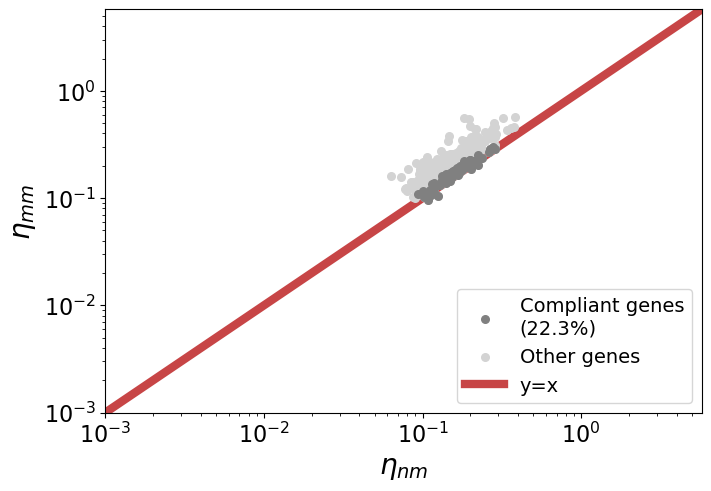

In [79]:
x=zeta_nm
y=zeta_mm

all_data = np.concatenate([x, y])
min_val, max_val = 1e-3, all_data.max()*10

plt.figure(figsize=(7,4.8))
plt.scatter(x[Bursty_mask],y[Bursty_mask],s=30,zorder=2,color='gray',label='Compliant genes\n('+str(np.around(100*np.mean(Bursty_mask),1))+"%)")
plt.scatter(x,y,s=30,color='lightgray',zorder=1,label='Other genes')
plt.loglog([min_val, max_val],[min_val, max_val],zorder=0,c=red,label='y=x')
plt.legend(loc='lower right',fontsize=14);
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel(r'$\eta_{nm}$',fontsize=20);
plt.ylabel(r'$\eta_{mm}$',fontsize=20);
#plt.savefig(figprefix+"_us.pdf", dpi=150)
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,3))+", CCC="+str(np.round(CCC(x,y),3)))

In [88]:
b_prime = zeta_nn*N_mean

2.2204316

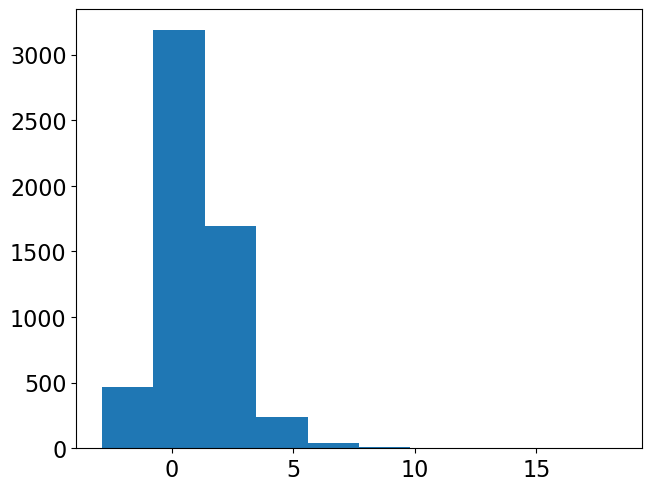

In [163]:
s = 0.1
idx = Bursty_mask  & (b_prime>0.1) 
X_ = M[:,idx]
X_mean = X_.mean(0)
c_1 = X_.sum(1)
c_1 = c_1/c_1.mean()
c_b = np.mean(( (X_-c_1[:,None]*X_mean[None,:])**2 - X_ )/c_1[:,None]/X_mean[None,:], axis=1)
c_b /= c_b.mean()
plt.hist(c_b)
c_b.var()

(array([55.,  7.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 2.83678699,  5.11022091,  7.38365507,  9.65708923, 11.93052292,
        14.2039566 , 16.47739029, 18.75082588, 21.02425957, 23.29769325,
        25.57112694]),
 <BarContainer object of 10 artists>)

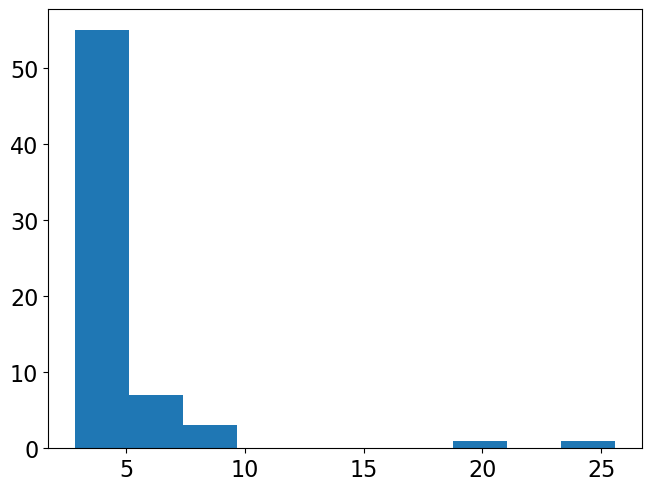

In [164]:
Y = ((X_ - c_1[:,None]*X_mean[None,:])**2 - c_1[:,None]*X_mean[None,:])/X_mean[None,:]
s_b=Y.var(0)
plt.hist(s_b)

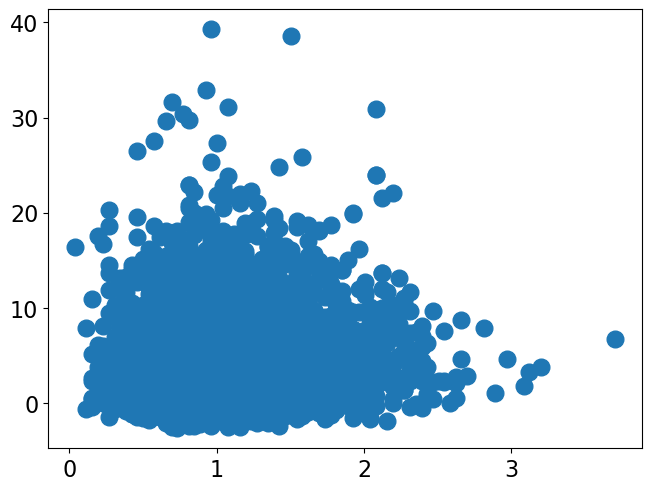

In [135]:
plt.scatter(c_a,c_b)

10.883762

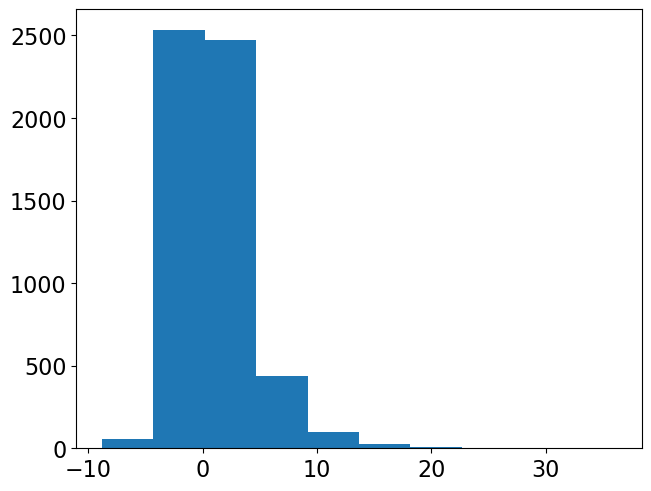

In [123]:
s = 0.1
X_ = N[:,Bursty_mask]
X_mean = X_.mean(0)
c_b = np.sum((X_**2 - X_ - (c_1[:,None]*X_mean[None,:])**2)/c_1[:,None]/X_mean[None,:], axis=1)
c_b /= c_b.mean()
plt.hist(c_b)
c_b.var()